In [1]:
# Cell 1
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import os
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import random
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from keras.utils import custom_object_scope

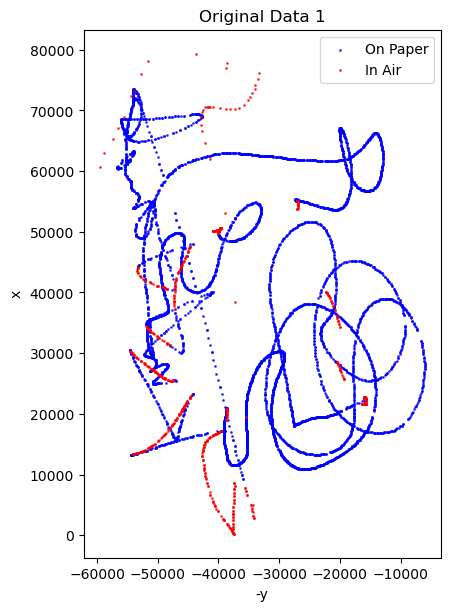

Number of processed files: 1
Average number of data points: 6508


In [60]:
# Cell 2
# Updated function
def upload_and_process_files(directory, num_files_to_use=None):
    svc_files = [f for f in os.listdir(directory) if f.endswith('.svc')]
    
    # If num_files_to_use is specified, only take that many files sequentially
    if num_files_to_use:
        svc_files = svc_files[:num_files_to_use]  # Take the first num_files_to_use files

    data_frames = []  # Processed data after scaling
    original_data_frames = []  # Save the original unscaled data
    scalers = []
    input_filenames = []  # List to store input filenames

    num_files = len(svc_files)
    fig, axs = plt.subplots(1, num_files, figsize=(6*num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]

    # Create the folder if it doesn't exist
    output_folder = 'original_absolute'
    os.makedirs(output_folder, exist_ok=True)

    for i, filename in enumerate(svc_files):
        file_path = os.path.join(directory, filename)
        input_filenames.append(filename)  # Store the filename
        df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        
        # Modify timestamp to start from 0
        df['timestamp'] = (df['timestamp'] - df['timestamp'].min()).round().astype(int)
        
        # Save the modified data to the 'original_absolute' folder
        save_path = os.path.join(output_folder, filename)
        df.to_csv(save_path, sep=' ', index=False, header=False)
        
        # Keep a copy of the original data before scaling
        original_data_frames.append(df.copy())  # Save the original unmodified data
        
        # Process the data for use in the model
        df = df.iloc[:, [0, 1, 2, 3, 4, 5, 6]] 
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y', 'timestamp']])
        scalers.append(scaler)

        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]
        axs[i].scatter(-on_paper['y'], on_paper['x'], c='blue', s=1, alpha=0.7, label='On Paper')
        axs[i].scatter(-in_air['y'], in_air['x'], c='red', s=1, alpha=0.7, label='In Air')
        axs[i].set_title(f'Original Data {i + 1}')
        axs[i].set_xlabel('-y')
        axs[i].set_ylabel('x')
        axs[i].legend()
        axs[i].set_aspect('equal')

    plt.show()

    processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                      for df, scaler in zip(data_frames, scalers)]
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, processed_data, scalers, avg_data_points, input_filenames, original_data_frames  # Return original data

directory = 'Try'  # Directory where the .svc files are stored
num_files_to_use = 1
data_frames, processed_data, scalers, avg_data_points, input_filenames, original_data_frames = upload_and_process_files(directory, num_files_to_use)

# Store the name of the first file for use in Cell 4
input_filename = input_filenames[0] if input_filenames else 'processed_data'
print(f"Number of processed files: {len(processed_data)}")
print(f"Average number of data points: {avg_data_points}")


In [67]:
# Cell 3
# Process each DataFrame instead of just the first one
for df_idx in range(len(data_frames)):
    df = data_frames[df_idx]  # Using each DataFrame in the list

    # Convert the 'timestamp' column to numeric for calculations (if not already done)
    df['timestamp'] = pd.to_numeric(df['timestamp'])

    # Sort the DataFrame by timestamp (should already be sorted in the function)
    df.sort_values('timestamp', inplace=True)

    # Calculate the differences between consecutive timestamps (optional for gap finding)
    df['time_diff'] = df['timestamp'].diff()

    # Identify the indices where the time difference is greater than 30,000 milliseconds
    gap_indices = df.index[df['time_diff'] > 1].tolist()

    # Create an empty list to hold the new rows
    new_rows = []

    # Fill in the gaps with 70 milliseconds intervals
    for idx in gap_indices:
        # Check if the next index is valid
        if idx + 1 < len(df):
            # Get the current and next timestamps
            current_timestamp = df.at[idx, 'timestamp']
            next_timestamp = df.at[idx + 1, 'timestamp']

            # Calculate how many entries we need to fill in
            num_fill_entries = (next_timestamp - current_timestamp) // 1

            # Generate the timestamps to fill the gap
            for i in range(1, num_fill_entries + 1):
                new_timestamp = current_timestamp + i * 1

                # Create a new row to fill in with NaN for x and y
                new_row = {
                    'x': np.nan,  # Set x to NaN
                    'y': np.nan,  # Set y to NaN
                    'timestamp': new_timestamp,
                    'pen_status': 0,        # You can set this to your desired value
                    'azimuth': df.at[idx, 'azimuth'],   # Use the current azimuth value
                    'altitude': df.at[idx, 'altitude'], # Use the current altitude value
                    'pressure': df.at[idx, 'pressure']  # Use the current pressure value
                }

                # Append the new row to the list of new rows
                new_rows.append(new_row)

    # Create a DataFrame from the new rows
    new_rows_df = pd.DataFrame(new_rows)

    # Concatenate the original DataFrame with the new rows DataFrame
    df = pd.concat([df, new_rows_df], ignore_index=True)

    # Sort the DataFrame by timestamp to maintain order
    df.sort_values('timestamp', inplace=True)

    # Reset index after sorting
    df.reset_index(drop=True, inplace=True)

    # Interpolate NaN values in 'x' and 'y' columns based on nearest neighbors
    # Check for NaN entries before interpolation
    if df[['x', 'y']].isnull().any().any():
        df[['x', 'y']] = df[['x', 'y']].interpolate(method='linear')

    # Drop the 'time_diff' column after processing
    df.drop(columns=['time_diff'], inplace=True)

    # Update the processed data
    data_frames[df_idx] = df

# Update processed data for all DataFrames
processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                  for df, scaler in zip(data_frames, scalers)]
avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

In [68]:

# Cell 4
##### Start
# Create the 'imputed' folder if it doesn't exist
imputed_folder = 'imputed'
os.makedirs(imputed_folder, exist_ok=True)
##### End
processed_dataframes = []

for input_filename, df in zip(input_filenames, data_frames):
    # Convert all numeric columns to integers
    df[['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']] = df[['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']].astype(int)

    #########Start
    # Save the processed DataFrame to the 'imputed' folder with the same input filename
    save_path = os.path.join(imputed_folder, input_filename)
    df.to_csv(save_path, sep=' ', index=False, header=False)  # Save without header and index
    ##########Emd
    # Append the processed DataFrame to the list
    processed_dataframes.append(df)

    print(f"Processed DataFrame saved as: {input_filename}")

Processed DataFrame saved as: aaaaaa.svc


In [69]:
# Cell 5 (modified, no visualization)
def process_dataframes(dataframes, num_files_to_use=None):
    if num_files_to_use:
        dataframes = dataframes[:num_files_to_use]

    data_frames = []
    scalers = []

    for i, df in enumerate(dataframes):
        # Modify timestamp to start from 0
        df['timestamp'] = (df['timestamp'] - df['timestamp'].min()).round().astype(int)
        
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y', 'timestamp']])
        scalers.append(scaler)

        # Print the first few rows of the timestamp column
        print(f"Modified timestamps for DataFrame {i + 1}:")
        print(df['timestamp'].head())
        print("\n")

    processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                      for df, scaler in zip(data_frames, scalers)]
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, processed_data, scalers, avg_data_points, [f"DataFrame_{i+1}" for i in range(len(dataframes))]

# Use the processed_dataframes directly
data_frames, processed_data, scalers, avg_data_points, original_filenames = process_dataframes(processed_dataframes, num_files_to_use)
print(f"Number of processed files: {len(processed_data)}")
# print(f"Average number of data points: {avg_data_points}")


Modified timestamps for DataFrame 1:
0    0
1    0
2    0
3    1
4    1
Name: timestamp, dtype: int32


Number of processed files: 1


In [70]:
# Cell 6 (modified)
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, beta=1.0, lambda_shift=0.01, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.latent_dim = latent_dim
        self.beta = beta
        self.lambda_shift = lambda_shift
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(4,)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(latent_dim * 2)
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(4)
        ])

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        # Apply shift correction
        return eps * tf.exp(logvar * .5) + (mean + self.lambda_shift * tf.exp(logvar * .5))

    def decode(self, z):
        decoded = self.decoder(z)
        xy_timestamp = tf.sigmoid(decoded[:, :3])
        pen_status = tf.sigmoid(decoded[:, 3])
        return tf.concat([xy_timestamp, tf.expand_dims(pen_status, -1)], axis=1)

    def call(self, inputs):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar

    @classmethod
    def from_config(cls, config):
        config.pop('trainable', None)
        config.pop('dtype', None)
        return cls(**config)

    def get_config(self):
        config = super(VAE, self).get_config()
        config.update({
            'latent_dim': self.latent_dim,
            'beta': self.beta,
            'lambda_shift': self.lambda_shift
        })
        return config


# New: LSTM Discriminator for GAN
class LSTMDiscriminator(tf.keras.Model):
    def __init__(self):
        super(LSTMDiscriminator, self).__init__()
        self.model = Sequential()
        self.model.add(LSTM(64, return_sequences=True, input_shape=(None, 4)))  # LSTM for sequence learning
        self.model.add(LSTM(32))
        self.model.add(Dense(1, activation='sigmoid'))  # Binary classification

    def call(self, x):
        return self.model(x)


# Function to compute VAE loss
def compute_loss(model, x):
    x_reconstructed, mean, logvar = model(x)
    reconstruction_loss_xy_timestamp = tf.reduce_mean(tf.keras.losses.mse(x[:, :3], x_reconstructed[:, :3]))
    reconstruction_loss_pen = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x[:, 3], x_reconstructed[:, 3]))
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))
    return reconstruction_loss_xy_timestamp + reconstruction_loss_pen, kl_loss, model.beta * kl_loss


# Parameters for VAE
latent_dim = 128
beta = 0.000001
learning_rate = 0.001
lambda_shift = 0.5

vae = VAE(latent_dim, beta)
optimizer = tf.keras.optimizers.Adam(learning_rate)


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [71]:
# Cell 7 (modified)
def generate_augmented_data(model, num_augmented_files, avg_data_points, processed_data, base_latent_variability=1.0, latent_variability_range=(0.5, 2.0)):
    augmented_datasets = []
    num_input_files = len(processed_data)
    
    for i in range(num_augmented_files):
        selected_data = processed_data[i % num_input_files]
        original_data = data_frames[i % num_input_files]
        pressure_azimuth_altitude = original_data[['pressure', 'azimuth', 'altitude']].values
        
        latent_variability = base_latent_variability * np.random.uniform(latent_variability_range[0], latent_variability_range[1])
        
        mean, logvar = model.encode(tf.convert_to_tensor(selected_data, dtype=tf.float32))
        z = model.reparameterize(mean, logvar * latent_variability)
        
        augmented_data = model.decode(z).numpy()

        augmented_data[:, 3] = post_process_pen_status(augmented_data[:, 3])
        augmented_data[:, 2] = np.sort(augmented_data[:, 2])
        augmented_data = np.column_stack((augmented_data, pressure_azimuth_altitude[:augmented_data.shape[0]]))
        
        augmented_datasets.append(augmented_data)

    return augmented_datasets

# The post_process_pen_status function remains unchanged
def post_process_pen_status(pen_status, threshold=0.5, min_segment_length=5):
    binary_pen_status = (pen_status > threshold).astype(int)
    
    # Smooth out rapid changes
    for i in range(len(binary_pen_status) - min_segment_length):
        if np.all(binary_pen_status[i:i+min_segment_length] == binary_pen_status[i]):
            binary_pen_status[i:i+min_segment_length] = binary_pen_status[i]
    
    return binary_pen_status

c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epoch 1/100: 100%|██████████| 14/14 [00:06<00:00,  2.03batch/s, Generator Loss=0.000771, Reconstruction Loss=0.000763, KL Loss=7.69]


Epoch 1: Generator Loss = 0.000861, Reconstruction Loss = 0.000853, KL Divergence Loss = 7.496971
NRMSE = 0.291558


Epoch 2/100: 100%|██████████| 14/14 [00:00<00:00, 36.36batch/s, Generator Loss=0.000856, Reconstruction Loss=0.000848, KL Loss=7.5] 


Epoch 2: Generator Loss = 0.000880, Reconstruction Loss = 0.000873, KL Divergence Loss = 7.503904
NRMSE = 0.291901


Epoch 3/100: 100%|██████████| 14/14 [00:00<00:00, 30.18batch/s, Generator Loss=0.000677, Reconstruction Loss=0.00067, KL Loss=7.65] 


Epoch 3: Generator Loss = 0.000829, Reconstruction Loss = 0.000822, KL Divergence Loss = 7.516860
NRMSE = 0.292645


Epoch 4/100: 100%|██████████| 14/14 [00:00<00:00, 21.26batch/s, Generator Loss=0.000873, Reconstruction Loss=0.000865, KL Loss=7.37]


Epoch 4: Generator Loss = 0.000872, Reconstruction Loss = 0.000864, KL Divergence Loss = 7.524495
NRMSE = 0.292887


Epoch 5/100: 100%|██████████| 14/14 [00:00<00:00, 37.37batch/s, Generator Loss=0.000956, Reconstruction Loss=0.000949, KL Loss=7.48]


Epoch 5: Generator Loss = 0.000941, Reconstruction Loss = 0.000933, KL Divergence Loss = 7.526225
NRMSE = 0.292363


Epoch 6/100: 100%|██████████| 14/14 [00:00<00:00, 37.72batch/s, Generator Loss=0.000856, Reconstruction Loss=0.000849, KL Loss=7.56]


Epoch 6: Generator Loss = 0.000970, Reconstruction Loss = 0.000963, KL Divergence Loss = 7.511837
NRMSE = 0.293028


Epoch 7/100: 100%|██████████| 14/14 [00:00<00:00, 40.02batch/s, Generator Loss=0.000611, Reconstruction Loss=0.000603, KL Loss=7.48]


Epoch 7: Generator Loss = 0.000854, Reconstruction Loss = 0.000846, KL Divergence Loss = 7.485761
NRMSE = 0.292826


Epoch 8/100: 100%|██████████| 14/14 [00:00<00:00, 35.52batch/s, Generator Loss=0.000759, Reconstruction Loss=0.000752, KL Loss=7.54]


Epoch 8: Generator Loss = 0.000863, Reconstruction Loss = 0.000856, KL Divergence Loss = 7.487545
NRMSE = 0.293987


Epoch 9/100: 100%|██████████| 14/14 [00:00<00:00, 21.44batch/s, Generator Loss=0.000732, Reconstruction Loss=0.000724, KL Loss=7.35]


Epoch 9: Generator Loss = 0.000780, Reconstruction Loss = 0.000773, KL Divergence Loss = 7.498600
NRMSE = 0.293423


Epoch 10/100: 100%|██████████| 14/14 [00:00<00:00, 35.48batch/s, Generator Loss=0.000891, Reconstruction Loss=0.000883, KL Loss=7.67]


Epoch 10: Generator Loss = 0.000811, Reconstruction Loss = 0.000804, KL Divergence Loss = 7.523259
NRMSE = 0.293333


Epoch 11/100: 100%|██████████| 14/14 [00:00<00:00, 31.85batch/s, Generator Loss=0.000783, Reconstruction Loss=0.000775, KL Loss=7.65]


Epoch 11: Generator Loss = 0.000803, Reconstruction Loss = 0.000796, KL Divergence Loss = 7.528451
NRMSE = 0.293839


Epoch 12/100: 100%|██████████| 14/14 [00:00<00:00, 43.91batch/s, Generator Loss=0.000839, Reconstruction Loss=0.000831, KL Loss=7.52]


Epoch 12: Generator Loss = 0.000810, Reconstruction Loss = 0.000803, KL Divergence Loss = 7.543686
NRMSE = 0.294974


Epoch 13/100: 100%|██████████| 14/14 [00:00<00:00, 40.58batch/s, Generator Loss=0.000677, Reconstruction Loss=0.00067, KL Loss=7.5]  


Epoch 13: Generator Loss = 0.000771, Reconstruction Loss = 0.000763, KL Divergence Loss = 7.545911
NRMSE = 0.293911


Epoch 14/100: 100%|██████████| 14/14 [00:00<00:00, 20.19batch/s, Generator Loss=0.000708, Reconstruction Loss=0.000701, KL Loss=7.4] 


Epoch 14: Generator Loss = 0.000745, Reconstruction Loss = 0.000737, KL Divergence Loss = 7.557690
NRMSE = 0.294793


Epoch 15/100: 100%|██████████| 14/14 [00:00<00:00, 40.53batch/s, Generator Loss=0.00084, Reconstruction Loss=0.000832, KL Loss=7.63] 


Epoch 15: Generator Loss = 0.000822, Reconstruction Loss = 0.000815, KL Divergence Loss = 7.585297
NRMSE = 0.294310


Epoch 16/100: 100%|██████████| 14/14 [00:00<00:00, 40.50batch/s, Generator Loss=0.000758, Reconstruction Loss=0.000751, KL Loss=7.63]


Epoch 16: Generator Loss = 0.000776, Reconstruction Loss = 0.000768, KL Divergence Loss = 7.584121
NRMSE = 0.294401


Epoch 17/100: 100%|██████████| 14/14 [00:00<00:00, 39.78batch/s, Generator Loss=0.000912, Reconstruction Loss=0.000904, KL Loss=7.58]


Epoch 17: Generator Loss = 0.000824, Reconstruction Loss = 0.000816, KL Divergence Loss = 7.586080
NRMSE = 0.295273


Epoch 18/100: 100%|██████████| 14/14 [00:00<00:00, 23.09batch/s, Generator Loss=0.000809, Reconstruction Loss=0.000802, KL Loss=7.61]


Epoch 18: Generator Loss = 0.000791, Reconstruction Loss = 0.000784, KL Divergence Loss = 7.580610
NRMSE = 0.295589


Epoch 19/100: 100%|██████████| 14/14 [00:00<00:00, 43.25batch/s, Generator Loss=0.000959, Reconstruction Loss=0.000951, KL Loss=7.72]


Epoch 19: Generator Loss = 0.000901, Reconstruction Loss = 0.000894, KL Divergence Loss = 7.586471
NRMSE = 0.295305


Epoch 20/100: 100%|██████████| 14/14 [00:00<00:00, 41.84batch/s, Generator Loss=0.00103, Reconstruction Loss=0.00102, KL Loss=7.5]   


Epoch 20: Generator Loss = 0.001028, Reconstruction Loss = 0.001020, KL Divergence Loss = 7.536336
NRMSE = 0.296674


Epoch 21/100: 100%|██████████| 14/14 [00:00<00:00, 40.31batch/s, Generator Loss=0.0011, Reconstruction Loss=0.00109, KL Loss=7.36]   


Epoch 21: Generator Loss = 0.000936, Reconstruction Loss = 0.000928, KL Divergence Loss = 7.486976
NRMSE = 0.295706


Epoch 22/100: 100%|██████████| 14/14 [00:00<00:00, 37.60batch/s, Generator Loss=0.000748, Reconstruction Loss=0.00074, KL Loss=7.38] 


Epoch 22: Generator Loss = 0.000922, Reconstruction Loss = 0.000914, KL Divergence Loss = 7.442664
NRMSE = 0.294205


Epoch 23/100: 100%|██████████| 14/14 [00:00<00:00, 26.69batch/s, Generator Loss=0.000746, Reconstruction Loss=0.000738, KL Loss=7.37]


Epoch 23: Generator Loss = 0.000836, Reconstruction Loss = 0.000828, KL Divergence Loss = 7.408444
NRMSE = 0.295297


Epoch 24/100: 100%|██████████| 14/14 [00:00<00:00, 24.88batch/s, Generator Loss=0.000769, Reconstruction Loss=0.000761, KL Loss=7.43]


Epoch 24: Generator Loss = 0.000742, Reconstruction Loss = 0.000735, KL Divergence Loss = 7.410537
NRMSE = 0.295327


Epoch 25/100: 100%|██████████| 14/14 [00:00<00:00, 45.68batch/s, Generator Loss=0.000817, Reconstruction Loss=0.000809, KL Loss=7.37]


Epoch 25: Generator Loss = 0.000720, Reconstruction Loss = 0.000713, KL Divergence Loss = 7.427029
NRMSE = 0.296066


Epoch 26/100: 100%|██████████| 14/14 [00:00<00:00, 42.33batch/s, Generator Loss=0.000723, Reconstruction Loss=0.000715, KL Loss=7.46]


Epoch 26: Generator Loss = 0.000743, Reconstruction Loss = 0.000735, KL Divergence Loss = 7.458259
NRMSE = 0.296905


Epoch 27/100: 100%|██████████| 14/14 [00:00<00:00, 44.09batch/s, Generator Loss=0.000693, Reconstruction Loss=0.000686, KL Loss=7.18]


Epoch 27: Generator Loss = 0.000713, Reconstruction Loss = 0.000706, KL Divergence Loss = 7.467285
NRMSE = 0.297452


Epoch 28/100: 100%|██████████| 14/14 [00:00<00:00, 28.98batch/s, Generator Loss=0.000899, Reconstruction Loss=0.000892, KL Loss=7.54]


Epoch 28: Generator Loss = 0.000761, Reconstruction Loss = 0.000754, KL Divergence Loss = 7.490536
NRMSE = 0.297146


Epoch 29/100: 100%|██████████| 14/14 [00:00<00:00, 33.43batch/s, Generator Loss=0.000665, Reconstruction Loss=0.000658, KL Loss=7.4] 


Epoch 29: Generator Loss = 0.000761, Reconstruction Loss = 0.000754, KL Divergence Loss = 7.487924
NRMSE = 0.297740


Epoch 30/100: 100%|██████████| 14/14 [00:00<00:00, 43.46batch/s, Generator Loss=0.000763, Reconstruction Loss=0.000755, KL Loss=7.53]


Epoch 30: Generator Loss = 0.000713, Reconstruction Loss = 0.000706, KL Divergence Loss = 7.491406
NRMSE = 0.297255


Epoch 31/100: 100%|██████████| 14/14 [00:00<00:00, 40.81batch/s, Generator Loss=0.00069, Reconstruction Loss=0.000683, KL Loss=7.51] 


Epoch 31: Generator Loss = 0.000738, Reconstruction Loss = 0.000731, KL Divergence Loss = 7.496696
NRMSE = 0.297115


Epoch 32/100: 100%|██████████| 14/14 [00:00<00:00, 40.93batch/s, Generator Loss=0.000815, Reconstruction Loss=0.000807, KL Loss=7.54]


Epoch 32: Generator Loss = 0.000672, Reconstruction Loss = 0.000664, KL Divergence Loss = 7.497400
NRMSE = 0.297922


Epoch 33/100: 100%|██████████| 14/14 [00:00<00:00, 25.60batch/s, Generator Loss=0.000552, Reconstruction Loss=0.000544, KL Loss=7.47]


Epoch 33: Generator Loss = 0.000671, Reconstruction Loss = 0.000663, KL Divergence Loss = 7.523144
NRMSE = 0.297679


Epoch 34/100: 100%|██████████| 14/14 [00:00<00:00, 28.08batch/s, Generator Loss=0.000879, Reconstruction Loss=0.000871, KL Loss=7.48]


Epoch 34: Generator Loss = 0.000716, Reconstruction Loss = 0.000708, KL Divergence Loss = 7.537196
NRMSE = 0.298430


Epoch 35/100: 100%|██████████| 14/14 [00:00<00:00, 35.82batch/s, Generator Loss=0.00074, Reconstruction Loss=0.000732, KL Loss=7.39] 


Epoch 35: Generator Loss = 0.000741, Reconstruction Loss = 0.000733, KL Divergence Loss = 7.542959
NRMSE = 0.299886


Epoch 36/100: 100%|██████████| 14/14 [00:00<00:00, 41.86batch/s, Generator Loss=0.000732, Reconstruction Loss=0.000724, KL Loss=7.61]


Epoch 36: Generator Loss = 0.000719, Reconstruction Loss = 0.000711, KL Divergence Loss = 7.536386
NRMSE = 0.299096


Epoch 37/100: 100%|██████████| 14/14 [00:00<00:00, 41.18batch/s, Generator Loss=0.000718, Reconstruction Loss=0.00071, KL Loss=7.71] 


Epoch 37: Generator Loss = 0.000649, Reconstruction Loss = 0.000642, KL Divergence Loss = 7.544126
NRMSE = 0.298496


Epoch 38/100: 100%|██████████| 14/14 [00:00<00:00, 31.37batch/s, Generator Loss=0.000809, Reconstruction Loss=0.000801, KL Loss=7.88]


Epoch 38: Generator Loss = 0.000701, Reconstruction Loss = 0.000694, KL Divergence Loss = 7.566810
NRMSE = 0.299632


Epoch 39/100: 100%|██████████| 14/14 [00:00<00:00, 35.18batch/s, Generator Loss=0.000746, Reconstruction Loss=0.000739, KL Loss=7.62]


Epoch 39: Generator Loss = 0.000693, Reconstruction Loss = 0.000686, KL Divergence Loss = 7.568052
NRMSE = 0.299985


Epoch 40/100: 100%|██████████| 14/14 [00:00<00:00, 39.96batch/s, Generator Loss=0.000872, Reconstruction Loss=0.000864, KL Loss=7.44]


Epoch 40: Generator Loss = 0.000783, Reconstruction Loss = 0.000776, KL Divergence Loss = 7.557100
NRMSE = 0.298160


Epoch 41/100: 100%|██████████| 14/14 [00:00<00:00, 41.30batch/s, Generator Loss=0.000702, Reconstruction Loss=0.000694, KL Loss=7.53]


Epoch 41: Generator Loss = 0.000728, Reconstruction Loss = 0.000721, KL Divergence Loss = 7.548810
NRMSE = 0.299837


Epoch 42/100: 100%|██████████| 14/14 [00:00<00:00, 42.00batch/s, Generator Loss=0.00072, Reconstruction Loss=0.000712, KL Loss=7.66] 


Epoch 42: Generator Loss = 0.000723, Reconstruction Loss = 0.000716, KL Divergence Loss = 7.545979
NRMSE = 0.300510


Epoch 43/100: 100%|██████████| 14/14 [00:00<00:00, 30.21batch/s, Generator Loss=0.000601, Reconstruction Loss=0.000594, KL Loss=7.55]


Epoch 43: Generator Loss = 0.000707, Reconstruction Loss = 0.000699, KL Divergence Loss = 7.531798
NRMSE = 0.300433


Epoch 44/100: 100%|██████████| 14/14 [00:00<00:00, 38.40batch/s, Generator Loss=0.000646, Reconstruction Loss=0.000639, KL Loss=7.5] 


Epoch 44: Generator Loss = 0.000704, Reconstruction Loss = 0.000696, KL Divergence Loss = 7.533696
NRMSE = 0.300763


Epoch 45/100: 100%|██████████| 14/14 [00:00<00:00, 43.06batch/s, Generator Loss=0.00066, Reconstruction Loss=0.000653, KL Loss=7.41] 


Epoch 45: Generator Loss = 0.000817, Reconstruction Loss = 0.000809, KL Divergence Loss = 7.516835
NRMSE = 0.301970


Epoch 46/100: 100%|██████████| 14/14 [00:00<00:00, 39.97batch/s, Generator Loss=0.000618, Reconstruction Loss=0.000611, KL Loss=7.41]


Epoch 46: Generator Loss = 0.000748, Reconstruction Loss = 0.000741, KL Divergence Loss = 7.491675
NRMSE = 0.303190


Epoch 47/100: 100%|██████████| 14/14 [00:00<00:00, 38.22batch/s, Generator Loss=0.00076, Reconstruction Loss=0.000753, KL Loss=7.42] 


Epoch 47: Generator Loss = 0.000743, Reconstruction Loss = 0.000736, KL Divergence Loss = 7.473825
NRMSE = 0.301811


Epoch 48/100: 100%|██████████| 14/14 [00:00<00:00, 19.79batch/s, Generator Loss=0.000769, Reconstruction Loss=0.000762, KL Loss=7.48]


Epoch 48: Generator Loss = 0.000690, Reconstruction Loss = 0.000683, KL Divergence Loss = 7.462688
NRMSE = 0.301566


Epoch 49/100: 100%|██████████| 14/14 [00:00<00:00, 41.89batch/s, Generator Loss=0.000756, Reconstruction Loss=0.000749, KL Loss=7.46]


Epoch 49: Generator Loss = 0.000692, Reconstruction Loss = 0.000684, KL Divergence Loss = 7.460359
NRMSE = 0.302544


Epoch 50/100: 100%|██████████| 14/14 [00:00<00:00, 41.69batch/s, Generator Loss=0.000515, Reconstruction Loss=0.000508, KL Loss=7.43]


Epoch 50: Generator Loss = 0.000650, Reconstruction Loss = 0.000642, KL Divergence Loss = 7.462430
NRMSE = 0.301531


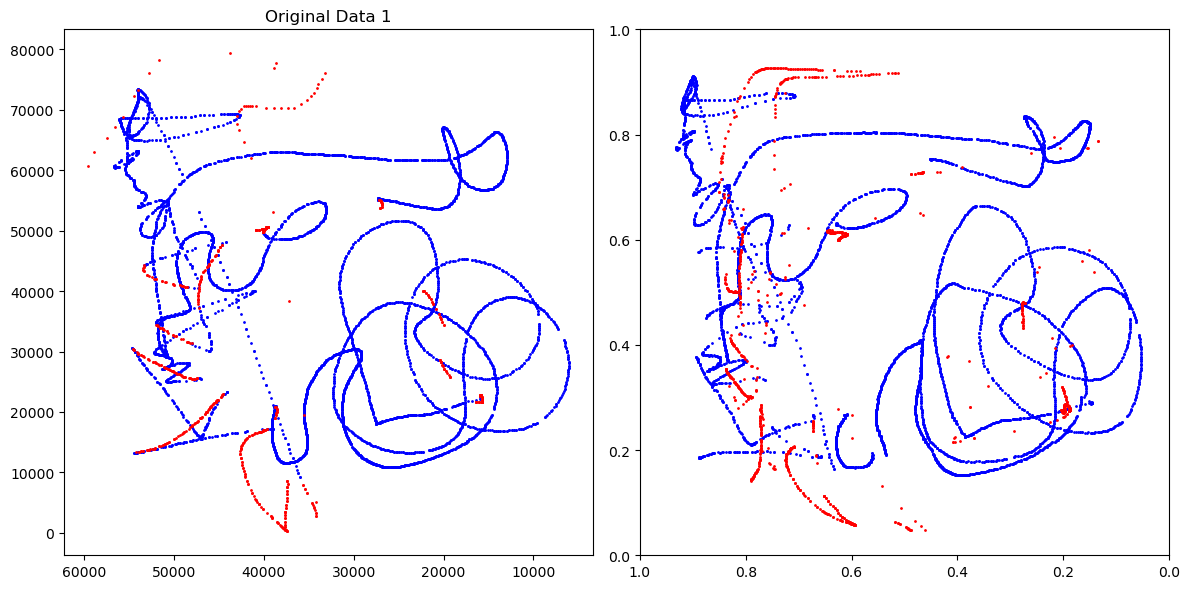

Epoch 51/100: 100%|██████████| 14/14 [00:00<00:00, 19.98batch/s, Generator Loss=0.000651, Reconstruction Loss=0.000644, KL Loss=7.5] 


Epoch 51: Generator Loss = 0.000624, Reconstruction Loss = 0.000617, KL Divergence Loss = 7.464744
NRMSE = 0.303611


Epoch 52/100: 100%|██████████| 14/14 [00:00<00:00, 41.15batch/s, Generator Loss=0.000581, Reconstruction Loss=0.000574, KL Loss=7.45]


Epoch 52: Generator Loss = 0.000689, Reconstruction Loss = 0.000682, KL Divergence Loss = 7.474983
NRMSE = 0.303745


Epoch 53/100: 100%|██████████| 14/14 [00:00<00:00, 42.15batch/s, Generator Loss=0.000682, Reconstruction Loss=0.000675, KL Loss=7.38]


Epoch 53: Generator Loss = 0.000622, Reconstruction Loss = 0.000615, KL Divergence Loss = 7.468395
NRMSE = 0.302990


Epoch 54/100: 100%|██████████| 14/14 [00:00<00:00, 39.83batch/s, Generator Loss=0.000587, Reconstruction Loss=0.000579, KL Loss=7.52]


Epoch 54: Generator Loss = 0.000631, Reconstruction Loss = 0.000623, KL Divergence Loss = 7.490736
NRMSE = 0.303992


Epoch 55/100: 100%|██████████| 14/14 [00:00<00:00, 41.79batch/s, Generator Loss=0.000647, Reconstruction Loss=0.000639, KL Loss=7.64]


Epoch 55: Generator Loss = 0.000623, Reconstruction Loss = 0.000615, KL Divergence Loss = 7.492654
NRMSE = 0.304291


Epoch 56/100: 100%|██████████| 14/14 [00:00<00:00, 30.23batch/s, Generator Loss=0.000739, Reconstruction Loss=0.000731, KL Loss=7.57]


Epoch 56: Generator Loss = 0.000666, Reconstruction Loss = 0.000659, KL Divergence Loss = 7.498589
NRMSE = 0.304975


Epoch 57/100: 100%|██████████| 14/14 [00:00<00:00, 34.78batch/s, Generator Loss=0.000743, Reconstruction Loss=0.000735, KL Loss=7.58]


Epoch 57: Generator Loss = 0.000669, Reconstruction Loss = 0.000661, KL Divergence Loss = 7.484250
NRMSE = 0.304055


Epoch 58/100: 100%|██████████| 14/14 [00:00<00:00, 41.06batch/s, Generator Loss=0.000638, Reconstruction Loss=0.000631, KL Loss=7.39]


Epoch 58: Generator Loss = 0.000711, Reconstruction Loss = 0.000703, KL Divergence Loss = 7.476208
NRMSE = 0.304723


Epoch 59/100: 100%|██████████| 14/14 [00:00<00:00, 41.50batch/s, Generator Loss=0.000622, Reconstruction Loss=0.000615, KL Loss=7.43]


Epoch 59: Generator Loss = 0.000631, Reconstruction Loss = 0.000623, KL Divergence Loss = 7.453858
NRMSE = 0.304560


Epoch 60/100: 100%|██████████| 14/14 [00:00<00:00, 41.25batch/s, Generator Loss=0.000638, Reconstruction Loss=0.000631, KL Loss=7.27]


Epoch 60: Generator Loss = 0.000630, Reconstruction Loss = 0.000623, KL Divergence Loss = 7.441324
NRMSE = 0.304365


Epoch 61/100: 100%|██████████| 14/14 [00:00<00:00, 21.59batch/s, Generator Loss=0.000738, Reconstruction Loss=0.000731, KL Loss=7.37]


Epoch 61: Generator Loss = 0.000606, Reconstruction Loss = 0.000599, KL Divergence Loss = 7.446037
NRMSE = 0.304620


Epoch 62/100: 100%|██████████| 14/14 [00:00<00:00, 41.10batch/s, Generator Loss=0.000573, Reconstruction Loss=0.000565, KL Loss=7.35]


Epoch 62: Generator Loss = 0.000648, Reconstruction Loss = 0.000641, KL Divergence Loss = 7.453384
NRMSE = 0.306193


Epoch 63/100: 100%|██████████| 14/14 [00:00<00:00, 39.43batch/s, Generator Loss=0.0005, Reconstruction Loss=0.000492, KL Loss=7.44]  


Epoch 63: Generator Loss = 0.000585, Reconstruction Loss = 0.000578, KL Divergence Loss = 7.451005
NRMSE = 0.306675


Epoch 64/100: 100%|██████████| 14/14 [00:00<00:00, 40.85batch/s, Generator Loss=0.000547, Reconstruction Loss=0.00054, KL Loss=7.44] 


Epoch 64: Generator Loss = 0.000578, Reconstruction Loss = 0.000571, KL Divergence Loss = 7.457900
NRMSE = 0.306172


Epoch 65/100: 100%|██████████| 14/14 [00:00<00:00, 39.78batch/s, Generator Loss=0.000622, Reconstruction Loss=0.000615, KL Loss=7.52]


Epoch 65: Generator Loss = 0.000581, Reconstruction Loss = 0.000574, KL Divergence Loss = 7.467262
NRMSE = 0.306358


Epoch 66/100: 100%|██████████| 14/14 [00:00<00:00, 18.93batch/s, Generator Loss=0.000707, Reconstruction Loss=0.000699, KL Loss=7.42]


Epoch 66: Generator Loss = 0.000648, Reconstruction Loss = 0.000640, KL Divergence Loss = 7.467906
NRMSE = 0.307394


Epoch 67/100: 100%|██████████| 14/14 [00:00<00:00, 26.46batch/s, Generator Loss=0.000515, Reconstruction Loss=0.000507, KL Loss=7.51]


Epoch 67: Generator Loss = 0.000607, Reconstruction Loss = 0.000600, KL Divergence Loss = 7.456306
NRMSE = 0.305557


Epoch 68/100: 100%|██████████| 14/14 [00:00<00:00, 41.73batch/s, Generator Loss=0.000708, Reconstruction Loss=0.000701, KL Loss=7.37]


Epoch 68: Generator Loss = 0.000634, Reconstruction Loss = 0.000627, KL Divergence Loss = 7.449616
NRMSE = 0.305711


Epoch 69/100: 100%|██████████| 14/14 [00:00<00:00, 40.78batch/s, Generator Loss=0.000621, Reconstruction Loss=0.000613, KL Loss=7.45]


Epoch 69: Generator Loss = 0.000627, Reconstruction Loss = 0.000620, KL Divergence Loss = 7.433959
NRMSE = 0.307884


Epoch 70/100: 100%|██████████| 14/14 [00:00<00:00, 38.79batch/s, Generator Loss=0.000654, Reconstruction Loss=0.000647, KL Loss=7.36]


Epoch 70: Generator Loss = 0.000576, Reconstruction Loss = 0.000569, KL Divergence Loss = 7.427188
NRMSE = 0.306748


Epoch 71/100: 100%|██████████| 14/14 [00:00<00:00, 20.58batch/s, Generator Loss=0.000584, Reconstruction Loss=0.000577, KL Loss=7.51]


Epoch 71: Generator Loss = 0.000594, Reconstruction Loss = 0.000587, KL Divergence Loss = 7.427641
NRMSE = 0.306346


Epoch 72/100: 100%|██████████| 14/14 [00:00<00:00, 36.80batch/s, Generator Loss=0.000709, Reconstruction Loss=0.000702, KL Loss=7.26]


Epoch 72: Generator Loss = 0.000691, Reconstruction Loss = 0.000683, KL Divergence Loss = 7.414505
NRMSE = 0.308963


Epoch 73/100: 100%|██████████| 14/14 [00:00<00:00, 40.47batch/s, Generator Loss=0.000737, Reconstruction Loss=0.00073, KL Loss=7.51] 


Epoch 73: Generator Loss = 0.000653, Reconstruction Loss = 0.000646, KL Divergence Loss = 7.397186
NRMSE = 0.308398


Epoch 74/100: 100%|██████████| 14/14 [00:00<00:00, 40.60batch/s, Generator Loss=0.000591, Reconstruction Loss=0.000583, KL Loss=7.26]


Epoch 74: Generator Loss = 0.000597, Reconstruction Loss = 0.000589, KL Divergence Loss = 7.371326
NRMSE = 0.308969


Epoch 75/100: 100%|██████████| 14/14 [00:00<00:00, 40.87batch/s, Generator Loss=0.00044, Reconstruction Loss=0.000433, KL Loss=7.39] 


Epoch 75: Generator Loss = 0.000590, Reconstruction Loss = 0.000583, KL Divergence Loss = 7.366409
NRMSE = 0.309481


Epoch 76/100: 100%|██████████| 14/14 [00:00<00:00, 20.60batch/s, Generator Loss=0.000532, Reconstruction Loss=0.000525, KL Loss=7.37]


Epoch 76: Generator Loss = 0.000520, Reconstruction Loss = 0.000513, KL Divergence Loss = 7.369109
NRMSE = 0.308577


Epoch 77/100: 100%|██████████| 14/14 [00:00<00:00, 41.57batch/s, Generator Loss=0.000535, Reconstruction Loss=0.000528, KL Loss=7.37]


Epoch 77: Generator Loss = 0.000545, Reconstruction Loss = 0.000538, KL Divergence Loss = 7.385926
NRMSE = 0.309901


Epoch 78/100: 100%|██████████| 14/14 [00:00<00:00, 36.78batch/s, Generator Loss=0.000524, Reconstruction Loss=0.000516, KL Loss=7.37]


Epoch 78: Generator Loss = 0.000520, Reconstruction Loss = 0.000512, KL Divergence Loss = 7.400395
NRMSE = 0.310138


Epoch 79/100: 100%|██████████| 14/14 [00:00<00:00, 42.15batch/s, Generator Loss=0.000675, Reconstruction Loss=0.000667, KL Loss=7.42]


Epoch 79: Generator Loss = 0.000557, Reconstruction Loss = 0.000549, KL Divergence Loss = 7.407898
NRMSE = 0.310513


Epoch 80/100: 100%|██████████| 14/14 [00:00<00:00, 21.62batch/s, Generator Loss=0.000617, Reconstruction Loss=0.00061, KL Loss=7.44] 


Epoch 80: Generator Loss = 0.000821, Reconstruction Loss = 0.000813, KL Divergence Loss = 7.384703
NRMSE = 0.309895


Epoch 81/100: 100%|██████████| 14/14 [00:00<00:00, 40.41batch/s, Generator Loss=0.000465, Reconstruction Loss=0.000458, KL Loss=7.24]


Epoch 81: Generator Loss = 0.000701, Reconstruction Loss = 0.000693, KL Divergence Loss = 7.311908
NRMSE = 0.310377


Epoch 82/100: 100%|██████████| 14/14 [00:00<00:00, 41.25batch/s, Generator Loss=0.000511, Reconstruction Loss=0.000504, KL Loss=7.18]


Epoch 82: Generator Loss = 0.000583, Reconstruction Loss = 0.000575, KL Divergence Loss = 7.264012
NRMSE = 0.310632


Epoch 83/100: 100%|██████████| 14/14 [00:00<00:00, 40.03batch/s, Generator Loss=0.000565, Reconstruction Loss=0.000558, KL Loss=7.15]


Epoch 83: Generator Loss = 0.000522, Reconstruction Loss = 0.000515, KL Divergence Loss = 7.256444
NRMSE = 0.310729


Epoch 84/100: 100%|██████████| 14/14 [00:00<00:00, 41.21batch/s, Generator Loss=0.000491, Reconstruction Loss=0.000484, KL Loss=7.16]


Epoch 84: Generator Loss = 0.000624, Reconstruction Loss = 0.000616, KL Divergence Loss = 7.268880
NRMSE = 0.311299


Epoch 85/100: 100%|██████████| 14/14 [00:00<00:00, 27.49batch/s, Generator Loss=0.000414, Reconstruction Loss=0.000407, KL Loss=7.12]


Epoch 85: Generator Loss = 0.000507, Reconstruction Loss = 0.000500, KL Divergence Loss = 7.259603
NRMSE = 0.312138


Epoch 86/100: 100%|██████████| 14/14 [00:00<00:00, 33.76batch/s, Generator Loss=0.000493, Reconstruction Loss=0.000485, KL Loss=7.33]


Epoch 86: Generator Loss = 0.000480, Reconstruction Loss = 0.000472, KL Divergence Loss = 7.280350
NRMSE = 0.311923


Epoch 87/100: 100%|██████████| 14/14 [00:00<00:00, 39.11batch/s, Generator Loss=0.000533, Reconstruction Loss=0.000526, KL Loss=7.33]


Epoch 87: Generator Loss = 0.000508, Reconstruction Loss = 0.000500, KL Divergence Loss = 7.304636
NRMSE = 0.312321


Epoch 88/100: 100%|██████████| 14/14 [00:00<00:00, 27.32batch/s, Generator Loss=0.000523, Reconstruction Loss=0.000515, KL Loss=7.42]


Epoch 88: Generator Loss = 0.000528, Reconstruction Loss = 0.000521, KL Divergence Loss = 7.314458
NRMSE = 0.313431


Epoch 89/100: 100%|██████████| 14/14 [00:00<00:00, 42.51batch/s, Generator Loss=0.000473, Reconstruction Loss=0.000466, KL Loss=7.23]


Epoch 89: Generator Loss = 0.000553, Reconstruction Loss = 0.000546, KL Divergence Loss = 7.306735
NRMSE = 0.312954


Epoch 90/100: 100%|██████████| 14/14 [00:00<00:00, 39.37batch/s, Generator Loss=0.00043, Reconstruction Loss=0.000423, KL Loss=7.21] 


Epoch 90: Generator Loss = 0.000528, Reconstruction Loss = 0.000521, KL Divergence Loss = 7.294904
NRMSE = 0.312005


Epoch 91/100: 100%|██████████| 14/14 [00:00<00:00, 20.12batch/s, Generator Loss=0.000514, Reconstruction Loss=0.000507, KL Loss=7.38]


Epoch 91: Generator Loss = 0.000461, Reconstruction Loss = 0.000454, KL Divergence Loss = 7.303761
NRMSE = 0.313009


Epoch 92/100: 100%|██████████| 14/14 [00:00<00:00, 41.57batch/s, Generator Loss=0.000566, Reconstruction Loss=0.000559, KL Loss=7.18]


Epoch 92: Generator Loss = 0.000487, Reconstruction Loss = 0.000479, KL Divergence Loss = 7.317760
NRMSE = 0.312457


Epoch 93/100: 100%|██████████| 14/14 [00:00<00:00, 40.79batch/s, Generator Loss=0.000461, Reconstruction Loss=0.000454, KL Loss=7.22]


Epoch 93: Generator Loss = 0.000488, Reconstruction Loss = 0.000481, KL Divergence Loss = 7.326242
NRMSE = 0.314492


Epoch 94/100: 100%|██████████| 14/14 [00:00<00:00, 39.64batch/s, Generator Loss=0.000357, Reconstruction Loss=0.00035, KL Loss=7.33] 


Epoch 94: Generator Loss = 0.000517, Reconstruction Loss = 0.000510, KL Divergence Loss = 7.325679
NRMSE = 0.313380


Epoch 95/100: 100%|██████████| 14/14 [00:00<00:00, 40.83batch/s, Generator Loss=0.000488, Reconstruction Loss=0.000481, KL Loss=7.11]


Epoch 95: Generator Loss = 0.000485, Reconstruction Loss = 0.000478, KL Divergence Loss = 7.311776
NRMSE = 0.312984


Epoch 96/100: 100%|██████████| 14/14 [00:00<00:00, 19.95batch/s, Generator Loss=0.000515, Reconstruction Loss=0.000508, KL Loss=7.1] 


Epoch 96: Generator Loss = 0.000444, Reconstruction Loss = 0.000437, KL Divergence Loss = 7.323061
NRMSE = 0.314878


Epoch 97/100: 100%|██████████| 14/14 [00:00<00:00, 40.54batch/s, Generator Loss=0.000443, Reconstruction Loss=0.000436, KL Loss=7.23]


Epoch 97: Generator Loss = 0.000473, Reconstruction Loss = 0.000466, KL Divergence Loss = 7.334793
NRMSE = 0.315289


Epoch 98/100: 100%|██████████| 14/14 [00:00<00:00, 41.63batch/s, Generator Loss=0.000482, Reconstruction Loss=0.000474, KL Loss=7.36]


Epoch 98: Generator Loss = 0.000541, Reconstruction Loss = 0.000534, KL Divergence Loss = 7.340724
NRMSE = 0.315162


Epoch 99/100: 100%|██████████| 14/14 [00:00<00:00, 41.42batch/s, Generator Loss=0.00054, Reconstruction Loss=0.000532, KL Loss=7.24] 


Epoch 99: Generator Loss = 0.000516, Reconstruction Loss = 0.000509, KL Divergence Loss = 7.313978
NRMSE = 0.315377


Epoch 100/100: 100%|██████████| 14/14 [00:00<00:00, 40.61batch/s, Generator Loss=0.000477, Reconstruction Loss=0.00047, KL Loss=7.28] 


Epoch 100: Generator Loss = 0.000476, Reconstruction Loss = 0.000469, KL Divergence Loss = 7.307816
NRMSE = 0.314901


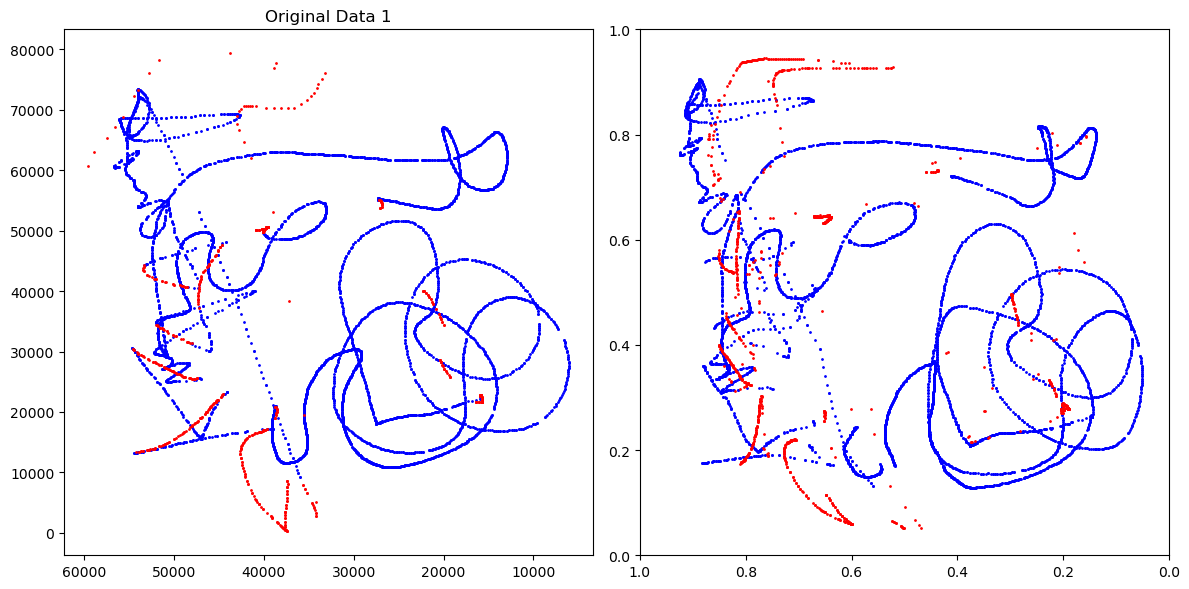

VAE model saved at pentab_vae_models\final_vae_model.h5.
Final VAE model saved.


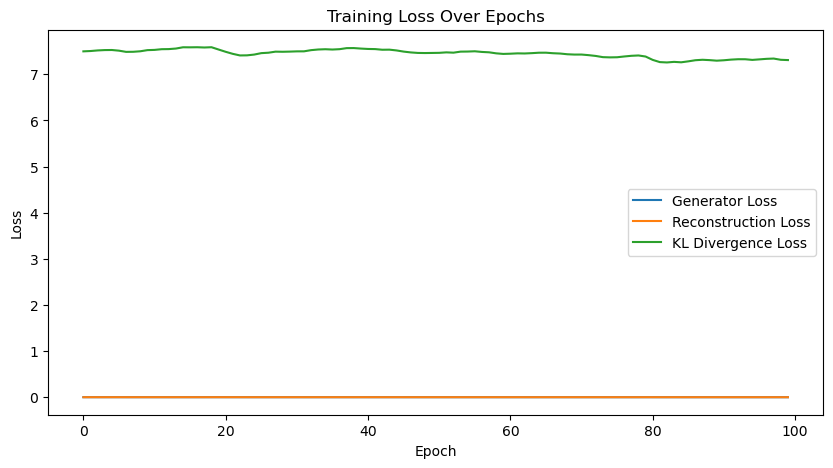

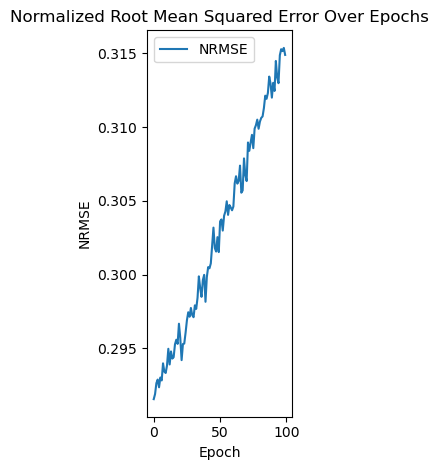

In [73]:
#Cell 8
@tf.function
def train_vae_step(model, x, optimizer, lstm_discriminator=None):
    with tf.GradientTape() as tape:
        x_reconstructed, mean, logvar = model(x)
        reconstruction_loss, kl_loss, total_kl_loss = compute_loss(model, x)
        
        # Add LSTM discriminator loss if available
        if lstm_discriminator is not None:
            real_predictions = lstm_discriminator(tf.expand_dims(x, axis=0))
            fake_predictions = lstm_discriminator(tf.expand_dims(x_reconstructed, axis=0))
            discriminator_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions) +
                                                tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_predictions), fake_predictions))
            generator_loss = reconstruction_loss + total_kl_loss + 0.1 * discriminator_loss  # Adjust the weight as needed
        else:
            generator_loss = reconstruction_loss + total_kl_loss
    
    gradients = tape.gradient(generator_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return generator_loss, reconstruction_loss, kl_loss

@tf.function
def train_lstm_step(lstm_model, real_data, generated_data, optimizer):
    with tf.GradientTape() as tape:
        real_predictions = lstm_model(real_data)
        generated_predictions = lstm_model(generated_data)
        real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions)
        generated_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(generated_predictions), generated_predictions)
        total_loss = real_loss + generated_loss
    gradients = tape.gradient(total_loss, lstm_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, lstm_model.trainable_variables))
    return total_loss

# Initialize LSTM discriminator and optimizer
lstm_discriminator = LSTMDiscriminator()
lstm_optimizer = tf.keras.optimizers.Adam(learning_rate)

batch_size = 512
train_datasets = [tf.data.Dataset.from_tensor_slices(data).shuffle(10000).batch(batch_size) for data in processed_data]

# Set up alternating epochs
vae_epochs = 200
lstm_interval = 50
epochs = 100
visual_per_num_epoch = 50
num_augmented_files = 1


generator_loss_history = []
reconstruction_loss_history = []
kl_loss_history = []
nrmse_history = []

save_dir = "pentab_vae_models"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for epoch in range(epochs):
    generator_loss = 0 
    reconstruction_loss_sum = 0
    kl_loss_sum = 0
    num_batches = sum(len(dataset) for dataset in train_datasets)

    with tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for dataset in train_datasets:
            for batch in dataset:
                use_lstm = epoch >= vae_epochs and (epoch - vae_epochs) % lstm_interval == 0
                generator_loss_batch, reconstruction_loss, kl_loss = train_vae_step(vae, batch, optimizer, lstm_discriminator if use_lstm else None)
                generator_loss += generator_loss_batch
                reconstruction_loss_sum += reconstruction_loss
                kl_loss_sum += kl_loss
                pbar.update(1)
                pbar.set_postfix({'Generator Loss': float(generator_loss_batch), 'Reconstruction Loss': float(reconstruction_loss), 'KL Loss': float(kl_loss)})

    # Train LSTM every `lstm_interval` epochs after `vae_epochs`
    if epoch >= vae_epochs and (epoch - vae_epochs) % lstm_interval == 0:
        for data in processed_data:
            augmented_data = vae.decode(tf.random.normal(shape=(data.shape[0], latent_dim))).numpy()
            real_data = tf.expand_dims(data, axis=0)
            generated_data = tf.expand_dims(augmented_data, axis=0)
            lstm_loss = train_lstm_step(lstm_discriminator, real_data, generated_data, lstm_optimizer)
        print(f'LSTM training at epoch {epoch+1}: Discriminator Loss = {lstm_loss.numpy()}')


    avg_generator_loss = generator_loss / num_batches  # Update the average calculation
    avg_reconstruction_loss = reconstruction_loss_sum / num_batches
    avg_kl_loss = kl_loss_sum / num_batches

    generator_loss_history.append(avg_generator_loss)  # Update history list
    reconstruction_loss_history.append(avg_reconstruction_loss)
    kl_loss_history.append(avg_kl_loss)

    # Calculate NRMSE
    nrmse_sum = 0
    for data in processed_data:
        augmented_data = vae.decode(tf.random.normal(shape=(data.shape[0], latent_dim))).numpy()
        rmse = np.sqrt(mean_squared_error(data[:, :2], augmented_data[:, :2]))
        nrmse = rmse / (data[:, :2].max() - data[:, :2].min())
        nrmse_sum += nrmse
    
    nrmse_avg = nrmse_sum / len(processed_data)

    nrmse_history.append(nrmse_avg)

    print(f"Epoch {epoch+1}: Generator Loss = {avg_generator_loss:.6f}, Reconstruction Loss = {avg_reconstruction_loss:.6f}, KL Divergence Loss = {avg_kl_loss:.6f}")
    print(f"NRMSE = {nrmse_avg:.6f}")



    # Cell 5 (visualization part)
    if (epoch + 1) % visual_per_num_epoch == 0:
        base_latent_variability = 100.0
        latent_variability_range = (0.1, 5.0)

        augmented_datasets = generate_augmented_data(vae, num_augmented_files, avg_data_points, processed_data, 
                                                     base_latent_variability, latent_variability_range)

        # Calculate actual latent variabilities and lengths used
        latent_variabilities = [base_latent_variability * np.random.uniform(latent_variability_range[0], latent_variability_range[1]) for _ in range(num_augmented_files)]
        augmented_lengths = [len(data) for data in augmented_datasets]

        fig, axs = plt.subplots(1, num_augmented_files + len(original_data_frames), figsize=(6*(num_augmented_files + len(original_data_frames)), 6))

        for i, original_data in enumerate(original_data_frames):
            original_on_paper = original_data[original_data['pen_status'] == 1]
            original_in_air = original_data[original_data['pen_status'] == 0]

            axs[i].scatter(original_on_paper['y'], original_on_paper['x'], c='b', s=1, label='On Paper')
            axs[i].scatter(original_in_air['y'], original_in_air['x'], c='r', s=1, label='In Air')
            axs[i].set_title(f'Original Data {i+1}')
            axs[i].invert_xaxis()

        # Set consistent axis limits for square aspect ratio for both original and augmented data
        x_min = min(data[:, 0].min() for data in processed_data)
        x_max = max(data[:, 0].max() for data in processed_data)
        y_min = min(data[:, 1].min() for data in processed_data)
        y_max = max(data[:, 1].max() for data in processed_data)

        for i, (augmented_data, latent_var, length) in enumerate(zip(augmented_datasets, latent_variabilities, augmented_lengths)):
            augmented_on_paper = augmented_data[augmented_data[:, 3] == 1]
            augmented_in_air = augmented_data[augmented_data[:, 3] == 0]

            axs[i+len(original_data_frames)].scatter(augmented_on_paper[:, 1], augmented_on_paper[:, 0], c='b', s=1, label='On Paper')
            axs[i+len(original_data_frames)].scatter(augmented_in_air[:, 1], augmented_in_air[:, 0], c='r', s=1, label='In Air')
            axs[i+len(original_data_frames)].invert_xaxis()
            axs[i+len(original_data_frames)].set_xlim(y_max, y_min)
            axs[i+len(original_data_frames)].set_ylim(x_min, x_max)

        plt.tight_layout()
        plt.show()
    
# Save VAE model after each epoch, directly into the `vae_models` folder
model_save_path = os.path.join(save_dir, "final_vae_model.h5")
vae.save(model_save_path)
print(f"VAE model saved at {model_save_path}.")

# Final output and plots
plt.ioff()
plt.show()

vae.save('pentab_saved_model.h5')
print("Final VAE model saved.")

# Plot generator loss history
plt.figure(figsize=(10, 5))
plt.plot(generator_loss_history, label='Generator Loss')  # Update label
plt.plot(reconstruction_loss_history, label='Reconstruction Loss')
plt.plot(kl_loss_history, label='KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Plot NRMSE history
plt.subplot(1, 3, 3)
plt.plot(nrmse_history, label='NRMSE')
plt.xlabel('Epoch')
plt.ylabel('NRMSE')
plt.title('Normalized Root Mean Squared Error Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Pretrained VAE model loaded.
Starting augmentation iteration 1
Augmented data saved to augmented_data\synthetic_aaaaaa.svc
Augmented data saved to augmented_data_nested\aaaaaa.svc
Shape of augmented data for aaaaaa.svc: (6952, 7)
Completed augmentation iteration 1
Starting augmentation iteration 2


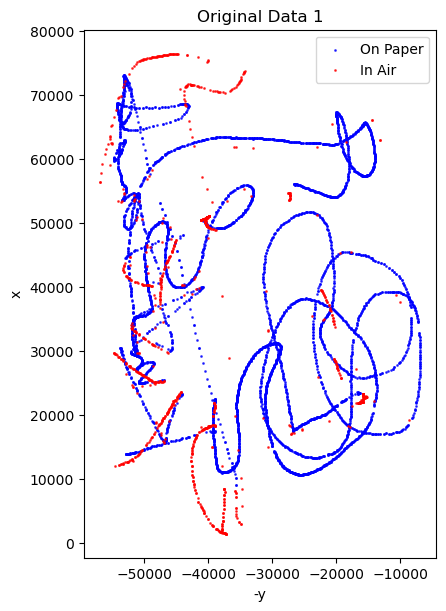

Augmented data saved to augmented_data\synthetic_aaaaaa(1).svc
Augmented data saved to augmented_data_nested\aaaaaa.svc
Shape of augmented data for aaaaaa.svc: (6951, 7)
Completed augmentation iteration 2
Starting augmentation iteration 3


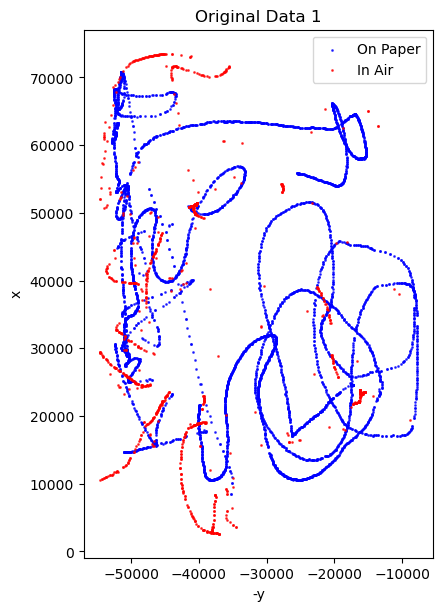

Augmented data saved to augmented_data\synthetic_aaaaaa(2).svc
Augmented data saved to augmented_data_nested\aaaaaa.svc
Shape of augmented data for aaaaaa.svc: (6950, 7)
Completed augmentation iteration 3
Cleared augmented_data_nested directory after the final iteration.
Nested augmentation process completed.


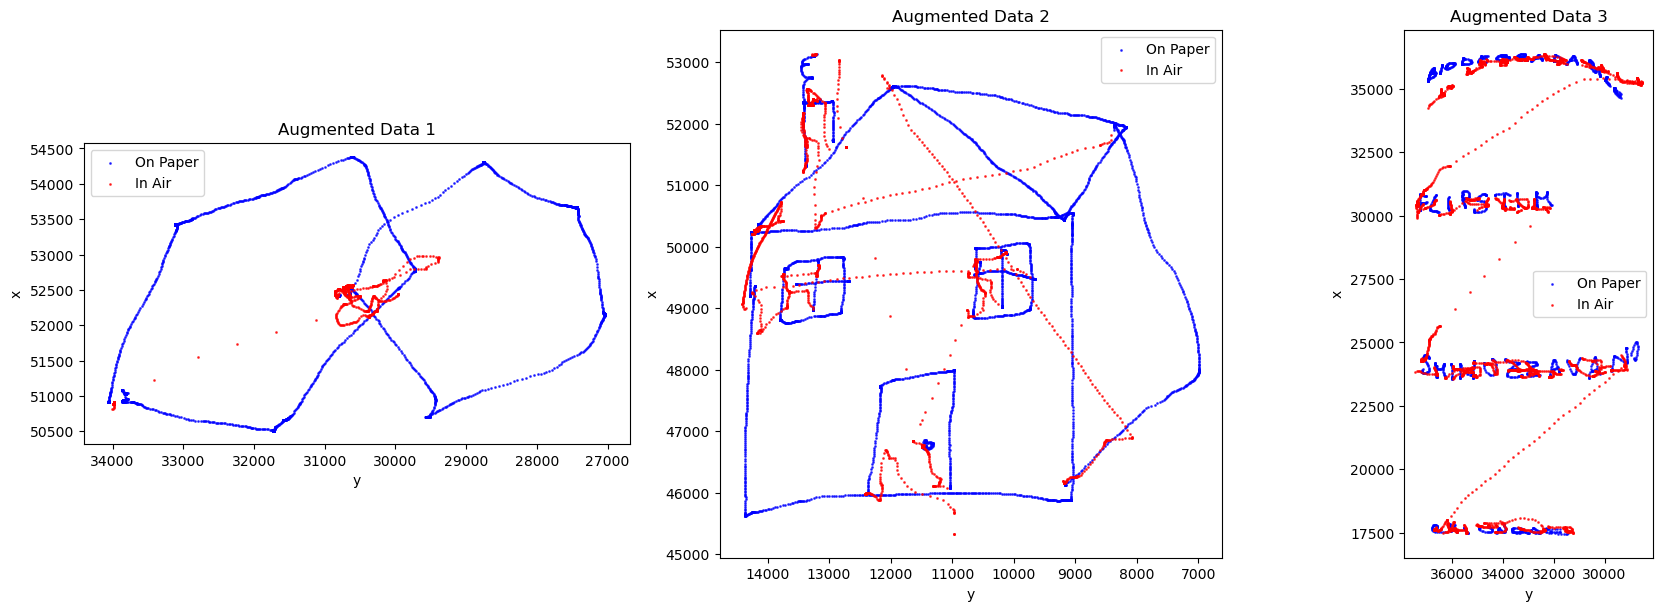

In [74]:
# Cell 9
import shutil

# Base latent variability settings
base_latent_variability = 100.0
latent_variability_range = (0.99, 1.01)
all_augmented_data = []  # Global list to store all augmented data

def repeat_backwards(original_paa, augmented_length):
    repeat_count = augmented_length - len(original_paa)
    if repeat_count <= 0:
        return original_paa
    backwards_rows = np.empty((0, original_paa.shape[1]))
    for i in range(repeat_count):
        row_to_repeat = original_paa[-(i % len(original_paa) + 1)]
        backwards_rows = np.vstack((backwards_rows, row_to_repeat))
    return np.vstack((original_paa, backwards_rows))

def visualize_augmented_data_from_directory(directory):
    augmented_files = [f for f in os.listdir(directory) if f.startswith('augmented_') and f.endswith('.svc')]
    num_files = len(augmented_files)
    if num_files == 0:
        print("No augmented data files found in the directory.")
        return
    
    fig, axs = plt.subplots(1, num_files, figsize=(6 * num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]
    
    for i, filename in enumerate(augmented_files):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path, delim_whitespace=True, header=None)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        
        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]

        axs[i].scatter(on_paper['y'], on_paper['x'], c='b', s=1, alpha=0.7, label='On Paper')
        axs[i].scatter(in_air['y'], in_air['x'], c='r', s=1, alpha=0.7, label='In Air')
        axs[i].set_title(f'Augmented Data {i + 1}')
        axs[i].set_xlabel('y')
        axs[i].set_ylabel('x')
        axs[i].invert_xaxis()
        axs[i].set_aspect('equal')
        axs[i].legend()
    
    plt.show()

def get_unique_filename(directory, filename):
    base, extension = os.path.splitext(filename)
    counter = 1
    while os.path.exists(os.path.join(directory, filename)):
        filename = f"{base}({counter}){extension}"
        counter += 1
    return filename

def download_augmented_data_with_modified_timestamp(augmented_datasets, scalers, original_data_frames, original_filenames, directory1='augmented_data', directory2='augmented_data_nested'):
    global all_augmented_data  # Access the global list

    if not os.path.exists(directory1):
        os.makedirs(directory1)
    
    if not os.path.exists(directory2):
        os.makedirs(directory2)

    for i, (augmented_data, scaler, original_df, original_filename) in enumerate(zip(augmented_datasets, scalers, original_data_frames, original_filenames)):
        augmented_xyz = scaler.inverse_transform(augmented_data[:, :3])
        augmented_xyz_int = np.rint(augmented_xyz).astype(int)
        pen_status = augmented_data[:, 3].astype(int)
        original_paa = original_df[['pressure', 'azimuth', 'altitude']].values
        
        if len(augmented_data) > len(original_paa):
            original_paa = repeat_backwards(original_paa, len(augmented_data))
        
        original_paa_int = np.rint(original_paa).astype(int)
        
        new_timestamps = np.zeros(len(augmented_data), dtype=int)
        increment_sequence = [7, 8]
        current_time = 0
        for idx in range(len(augmented_data)):
            new_timestamps[idx] = current_time
            current_time += increment_sequence[idx % 2]

        augmented_xyz_int[:, 2] = new_timestamps

        augmented_data_original_scale = np.column_stack((
            augmented_xyz_int,
            pen_status,
            original_paa_int[:len(augmented_data)]
        ))

        # Use the original filename for nested directory
        nested_filename = original_filename
        nested_file_path = os.path.join(directory2, nested_filename)

        # For augmented_data directory, add 'augmented_' prefix and handle duplicates
        augmented_filename = f"synthetic_{original_filename}"
        augmented_filename = get_unique_filename(directory1, augmented_filename)
        augmented_file_path = os.path.join(directory1, augmented_filename)

        np.savetxt(augmented_file_path, augmented_data_original_scale, fmt='%d', delimiter=' ')
        np.savetxt(nested_file_path, augmented_data_original_scale, fmt='%d', delimiter=' ')

        # Only store augmented data from the augmented_data directory
        all_augmented_data.append(augmented_data_original_scale)

        print(f"Augmented data saved to {augmented_file_path}")
        print(f"Augmented data saved to {nested_file_path}")
        print(f"Shape of augmented data for {original_filename}: {augmented_data_original_scale.shape}")

def nested_augmentation(num_augmentations, num_files_to_use):
    with custom_object_scope({'VAE': VAE}):
        vae_pretrained = load_model('vae_models/epoch_200_model.h5')
    print("Pretrained VAE model loaded.")

    # Use the existing data for the first iteration
    global data_frames, processed_data, scalers, avg_data_points, input_filenames, original_data_frames

    for iteration in range(num_augmentations):
        print(f"Starting augmentation iteration {iteration + 1}")
        
        if iteration > 0:
            # Only update the data for subsequent iterations
            directory = 'augmented_data_nested'
            data_frames, processed_data, scalers, avg_data_points, input_filenames, original_data_frames = upload_and_process_files(directory, num_files_to_use)
        
        augmented_datasets = generate_augmented_data(vae_pretrained, num_files_to_use, avg_data_points, processed_data, 
                                                     base_latent_variability, latent_variability_range)
        
        # Clear augmented_data_nested directory
        if os.path.exists('augmented_data_nested'):
            shutil.rmtree('augmented_data_nested')
        os.makedirs('augmented_data_nested')
        
        download_augmented_data_with_modified_timestamp(augmented_datasets, scalers, original_data_frames, input_filenames)
        
        print(f"Completed augmentation iteration {iteration + 1}")
    
    # Clear augmented_data_nested directory after the last iteration
    if os.path.exists('augmented_data_nested'):
        shutil.rmtree('augmented_data_nested')
        print("Cleared augmented_data_nested directory after the final iteration.")
    
    print("Nested augmentation process completed.")
    visualize_augmented_data_from_directory('augmented_data')
    

# Set the number of augmentations and files to use
num_augmentations = 3  # Change this to control the number of nested augmentations

# Run the nested augmentation process
nested_augmentation(num_augmentations, num_files_to_use)

In [82]:
# Cell 11 NRMSE
from glob import glob
import re

def read_svc_file(file_path):
    return pd.read_csv(file_path, sep=' ', header=None, 
                       names=['x', 'y', 'timestamp', 'pen_status'])

def calculate_nrmse(original, predicted):
    if original.shape != predicted.shape:
        raise ValueError("The shapes of the original and predicted datasets must match.")
    mse = np.mean((original - predicted) ** 2)
    rmse = np.sqrt(mse)
    nrmse = rmse / (np.max(original) - np.min(original))
    return nrmse

def get_matching_augmented_files(original_file, augmented_folder):
    base_name = os.path.basename(original_file)
    base_name_without_ext = os.path.splitext(base_name)[0]
    pattern = os.path.join(augmented_folder, f"synthetic_{base_name_without_ext}*.svc")
    matching_files = glob(pattern)
    
    # Sort files based on the number in parentheses, with the base file (no number) first
    def sort_key(filename):
        match = re.search(r'\((\d+)\)', filename)
        return int(match.group(1)) if match else -1
    
    return sorted(matching_files, key=sort_key)

def process_files(imputed_folder, augmented_folder, input_filenames):
    nrmse_results = {}

    # Create a set of base filenames (without extensions) for easy comparison
    input_filenames_set = {os.path.splitext(os.path.basename(filename))[0] for filename in input_filenames}

    for original_file in glob(os.path.join(imputed_folder, "*.svc")):
        base_name = os.path.splitext(os.path.basename(original_file))[0]
        
        # Only process files that are present in input_filenames
        if base_name not in input_filenames_set:
            continue
        
        file_name = os.path.basename(original_file)
        original_data = read_svc_file(original_file)
        
        matching_augmented_files = get_matching_augmented_files(original_file, augmented_folder)
        
        file_nrmse = []
        for augmented_file in matching_augmented_files:
            augmented_data = read_svc_file(augmented_file)
            
            # Trim to the shorter length
            min_length = min(len(original_data), len(augmented_data))
            original_array = original_data.iloc[:min_length].values
            augmented_array = augmented_data.iloc[:min_length].values
            
            nrmse = calculate_nrmse(original_array, augmented_array)
            file_nrmse.append(nrmse)
        
        nrmse_results[file_name] = file_nrmse

    return nrmse_results

# Define the folders directly in the notebook cell
imputed_folder = "imputed"
augmented_folder = "augmented_data"

# Process the files and calculate NRMSE
results = process_files(imputed_folder, augmented_folder, input_filenames)

# Display the results
for original_file, nrmse_values in results.items():
    print(f"Results for {original_file}:")
    for i, nrmse in enumerate(nrmse_values):
        augmented_version = f"({i})" if i > 0 else "base"
        print(f"  NRMSE for augmented version {augmented_version}: {nrmse:.4f}")
    
    if nrmse_values:
        avg_nrmse = np.mean(nrmse_values)
        print(f"  Average NRMSE: {avg_nrmse:.4f}")
    print()

# Calculate and display the overall average NRMSE
all_nrmse = [nrmse for nrmse_list in results.values() for nrmse in nrmse_list]
overall_avg_nrmse = np.mean(all_nrmse)
print(f"Overall Average NRMSE: {overall_avg_nrmse:.4f}")

Results for aaaaaa.svc:
  NRMSE for augmented version base: 0.0161
  NRMSE for augmented version (1): 0.0161
  NRMSE for augmented version (2): 0.0160
  Average NRMSE: 0.0161

Overall Average NRMSE: 0.0161


In [84]:
# Cell 12 Post-Hoc Discriminative Score
def process_files(imputed_folder, augmented_folder, input_filenames):
    all_real_data = []
    all_synthetic_data = []

    # Create a set of base filenames (without extensions) for easy comparison
    input_filenames_set = {os.path.splitext(os.path.basename(filename))[0] for filename in input_filenames}

    for original_file in glob(os.path.join(imputed_folder, "*.svc")):
        base_name = os.path.splitext(os.path.basename(original_file))[0]
        
        # Only process files that are present in input_filenames
        if base_name not in input_filenames_set:
            continue
        
        original_data = read_svc_file(original_file)
        all_real_data.append(original_data.values)
        
        matching_augmented_files = get_matching_augmented_files(original_file, augmented_folder)
        
        for augmented_file in matching_augmented_files:
            augmented_data = read_svc_file(augmented_file)
            all_synthetic_data.append(augmented_data.values)

    return np.concatenate(all_real_data), np.concatenate(all_synthetic_data)

def create_lstm_classifier(input_shape):
    model = Sequential([
        LSTM(16, input_shape=input_shape, return_sequences=True),
        LSTM(8),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def prepare_data_for_lstm(real_data, synthetic_data):
    n_features = min(real_data.shape[1], synthetic_data.shape[1])
    real_data_trimmed = real_data[:, :n_features]
    synthetic_data_trimmed = synthetic_data[:, :n_features]
    
    X = np.vstack((real_data_trimmed, synthetic_data_trimmed))
    y = np.concatenate((np.ones(len(real_data)), np.zeros(len(synthetic_data))))
    return X, y

def post_hoc_discriminative_score(real_data, synthetic_data, n_splits=10):
    X, y = prepare_data_for_lstm(real_data, synthetic_data)
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []
    
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold + 1}/{n_splits}:")  # New print statement for fold numbers
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

        model = create_lstm_classifier((1, X_train.shape[2]))
        
        # Train model and show epoch progress for this fold
        history = model.fit(X_train, y_train, epochs=2, batch_size=1024, verbose=1)

        y_pred = (model.predict(X_test) > 0.5).astype(int)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    return mean_accuracy, std_accuracy

# Specify your folders
imputed_folder = "imputed"
augmented_folder = "augmented_data"

# Process files, without NRMSE
real_data, synthetic_data = process_files(imputed_folder, augmented_folder, input_filenames)

# Compute post-hoc discriminative score
mean_accuracy, std_accuracy = post_hoc_discriminative_score(real_data, synthetic_data)

print(f"Mean accuracy: {mean_accuracy:.4f} (±{std_accuracy:.4f})")


Fold 1/10:


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.7504 - loss: 0.6774
Epoch 2/2
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7515 - loss: 0.6615
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step

Fold 2/10:


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.5264 - loss: 0.6947
Epoch 2/2
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7517 - loss: 0.6622
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step

Fold 3/10:


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.7509 - loss: 0.6521
Epoch 2/2
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7508 - loss: 0.6290
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step

Fold 4/10:


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.4733 - loss: 0.6922
Epoch 2/2
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7486 - loss: 0.6578
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step

Fold 5/10:


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.2825 - loss: 0.7153
Epoch 2/2
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7549 - loss: 0.6809
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step

Fold 6/10:


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2


ValueError: None values not supported.

In [85]:
# Cell 13 Post Hoc Predictive Score
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold
from keras.callbacks import Callback
from tqdm import tqdm

# Step 1: Prepare Data
def prepare_data(df, time_steps=5):
    data = df[['x', 'y']].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)
    
    # Create sequences of length `time_steps`
    X, y = [], []
    for i in range(len(data_scaled) - time_steps):
        X.append(data_scaled[i:i+time_steps])
        y.append(data_scaled[i+time_steps])
    
    return np.array(X), np.array(y), scaler

# Example usage
X, y, scaler = prepare_data(data_frames[0])

# Custom callback for progress bar
class CustomCallback(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.progress_bar = tqdm(total=self.epochs, desc="Training Progress")

    def on_epoch_end(self, epoch, logs=None):
        self.progress_bar.update(1)

    def on_train_end(self, logs=None):
        self.progress_bar.close()

# Step 2: Define the LSTM Model
def create_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))  # Adding dropout to introduce randomness
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(2))  # Predict x and y
    model.compile(optimizer='adam', loss='mse')
    return model

# Step 3: Evaluate Model Function
def evaluate_model(model, X_test, y_test, scaler):
    # Predict and inverse transform
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test)
    
    # Compute MAPE for each test sample
    mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)
    print(f"\nMAPE: {mape * 100:.2f}%")
    
    # Interpretation of MAPE
    if mape < 0.1:
        interpretation = "Excellent prediction"
    elif mape < 0.2:
        interpretation = "Good prediction"
    elif mape < 0.5:
        interpretation = "Fair prediction"
    else:
        interpretation = "Poor prediction"
    
    print(f"Interpretation: {interpretation}")
    
    return mape

# Step 4: K-Fold Cross-Validation Implementation
kf = KFold(n_splits=10, shuffle=True, random_state=np.random.randint(1000))  # 10-fold cross-validation

mape_values = []
for fold, (train_index, test_index) in enumerate(kf.split(X), start=1):
    print(f"\n--- Fold {fold} ---")
    
    # Split data into training and testing sets for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = create_model((X_train.shape[1], X_train.shape[2]))
    model.fit(X_train, y_train, epochs=5, batch_size=512, verbose=3, callbacks=[CustomCallback()])
    
    # Evaluate the model and store MAPE
    mape = evaluate_model(model, X_test, y_test, scaler)
    print(f"Fold {fold} MAPE: {mape * 100:.2f}%")  # Print MAPE for the current fold
    mape_values.append(mape)

# Step 5: Calculate Mean and Standard Deviation of MAPE
mean_mape = np.mean(mape_values)
std_mape = np.std(mape_values)

print(f"\nMean MAPE: {mean_mape * 100:.2f}%")
print(f"Standard Deviation of MAPE: {std_mape * 100:.2f}%")


--- Fold 1 ---


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5


Training Progress:  20%|██        | 1/5 [00:15<01:02, 15.73s/it]

Epoch 2/5


Training Progress:  40%|████      | 2/5 [00:17<00:23,  7.72s/it]

Epoch 3/5


Training Progress:  60%|██████    | 3/5 [00:18<00:09,  4.69s/it]

Epoch 4/5


Training Progress:  80%|████████  | 4/5 [00:21<00:03,  3.77s/it]

Epoch 5/5


Training Progress: 100%|██████████| 5/5 [00:22<00:00,  4.45s/it]


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step

MAPE: 9.87%
Interpretation: Excellent prediction
Fold 1 MAPE: 9.87%

--- Fold 2 ---


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5


Training Progress:  20%|██        | 1/5 [00:14<00:58, 14.64s/it]

Epoch 2/5


Training Progress:  40%|████      | 2/5 [00:16<00:22,  7.38s/it]

Epoch 3/5


Training Progress:  60%|██████    | 3/5 [00:19<00:10,  5.29s/it]

Epoch 4/5


Training Progress:  80%|████████  | 4/5 [00:20<00:03,  3.66s/it]

Epoch 5/5


Training Progress: 100%|██████████| 5/5 [00:23<00:00,  4.64s/it]


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step

MAPE: 11.04%
Interpretation: Good prediction
Fold 2 MAPE: 11.04%

--- Fold 3 ---


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5


KeyboardInterrupt: 

In [12]:
# Cell 9 (modified to retain augmented data length)
def download_augmented_data_as_integers(augmented_datasets, scalers, original_data_frames, original_filenames, directory='augmented_data'):
    if not os.path.exists(directory):
        os.makedirs(directory)

    for i, (augmented_data, scaler, original_df, original_filename) in enumerate(zip(augmented_datasets, scalers, original_data_frames, original_filenames)):
        # Inverse transform the augmented data
        augmented_xyz = scaler.inverse_transform(augmented_data[:, :3])
        
        # Round to integers
        augmented_xyz_int = np.rint(augmented_xyz).astype(int)
        
        # Get pen status from augmented data
        pen_status = augmented_data[:, 3].astype(int)
        
        # Prepare pressure, azimuth, altitude data
        original_paa = original_df[['pressure', 'azimuth', 'altitude']].values
        
        # If augmented data is longer, extend original_paa by repeating the last row
        if len(augmented_data) > len(original_paa):
            last_row = original_paa[-1:]
            repeat_count = len(augmented_data) - len(original_paa)
            extended_rows = np.tile(last_row, (repeat_count, 1))
            original_paa = np.vstack((original_paa, extended_rows))
        
        # Round pressure, azimuth, altitude to integers
        original_paa_int = np.rint(original_paa).astype(int)
        
        # Combine all data
        augmented_data_original_scale = np.column_stack((
            augmented_xyz_int,
            pen_status,
            original_paa_int[:len(augmented_data)]
        ))

        # Construct the new file name to match the original file name
        augmented_filename = f"augmented_{original_filename}"
        augmented_file_path = os.path.join(directory, augmented_filename)

        # Save the augmented data to a file
        np.savetxt(augmented_file_path, augmented_data_original_scale, fmt='%d', delimiter=' ')

        print(f"Augmented data saved to {augmented_file_path}")
        print(f"Shape of augmented data for {original_filename}: {augmented_data_original_scale.shape}")

# Example call to the function
download_augmented_data_as_integers(augmented_datasets, scalers, original_data_frames, input_filenames)

# Add this diagnostic print statement after generating augmented_datasets
print("Shapes of augmented datasets:")
for i, aug_data in enumerate(augmented_datasets):
    print(f"Shape of augmented dataset {i+1}: {aug_data.shape}")

Augmented data saved to augmented_data\augmented_u00001s00001_hw00002.svc
Shape of augmented data for u00001s00001_hw00002.svc: (5971, 7)
Shapes of augmented datasets:
Shape of augmented dataset 1: (5971, 7)


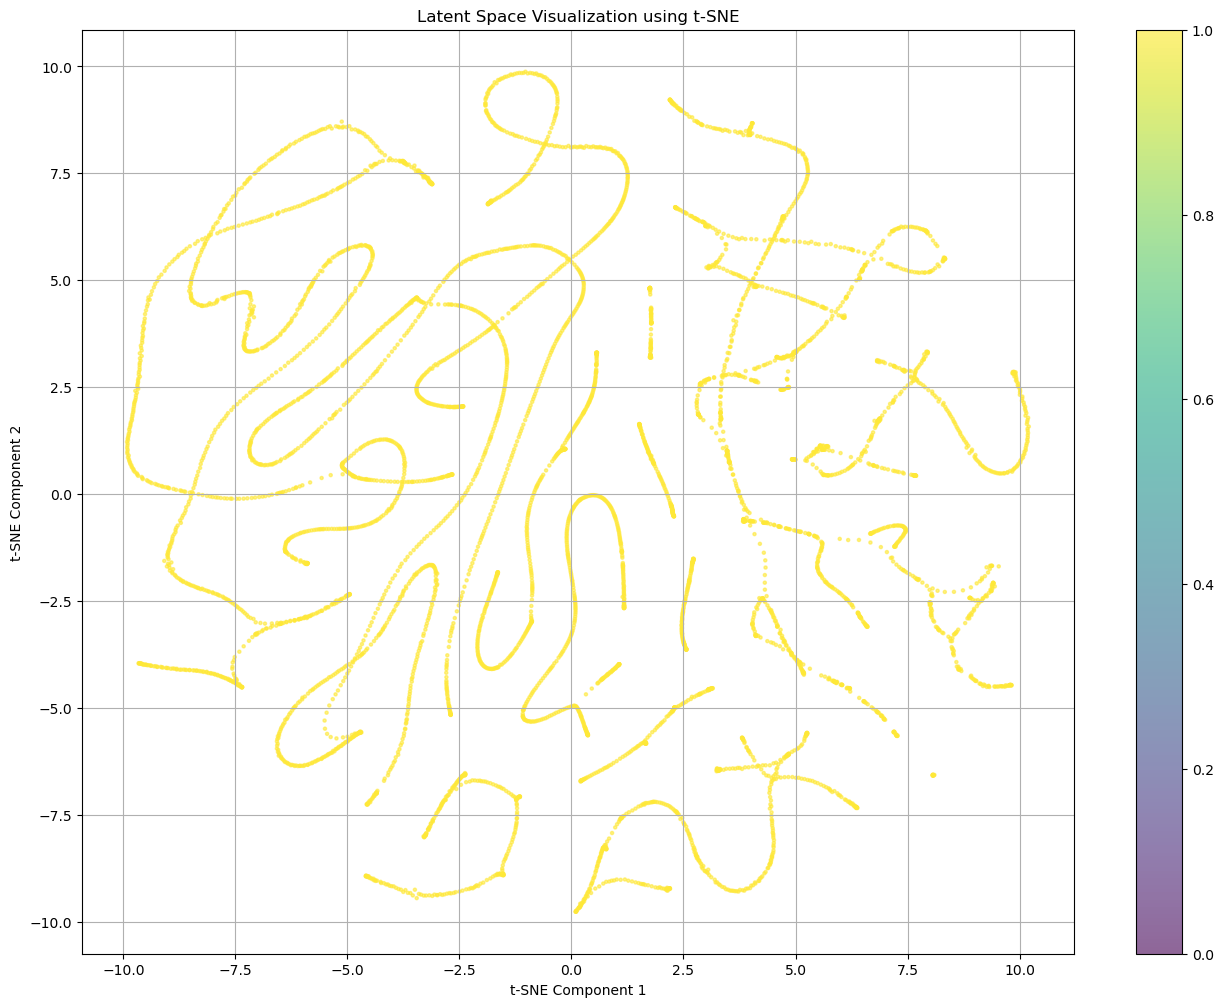

In [22]:
#Cell 11 Function to visualize the latent space with a color gradient
from sklearn.manifold import TSNE

def visualize_latent_space(model, data, perplexity=5, learning_rate=200, n_iter=250):
    # Encode data into the latent space
    latent_means, _ = model.encode(tf.convert_to_tensor(data, dtype=tf.float32))
    latent_means_np = latent_means.numpy()
    
    # Use t-SNE to reduce dimensionality to 2D
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter)
    latent_2d = tsne.fit_transform(latent_means_np)
    
    # Create a color map for the latent points
    norm = plt.Normalize(vmin=np.min(latent_means_np), vmax=np.max(latent_means_np))
    cmap = plt.cm.cividis  # You can change the colormap to 'plasma', 'inferno', etc.
    colors = cmap(norm(latent_means_np).sum(axis=1))  # Coloring based on the sum of latent variables
    
    # Plot the 2D t-SNE result with the color map
    plt.figure(figsize=(16, 12))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=colors, s=5, alpha=0.6)
    plt.colorbar(scatter)  # Add a color bar for the gradient
    plt.title('Latent Space Visualization using t-SNE')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True)
    plt.show()

# Visualize latent space for one of the processed datasets
visualize_latent_space(vae, processed_data[0])